In [1]:
""" minimalistic adiabatic parcel model using Numpy, pint, SciPy/odeint and matplotlib """
import math
import pint
import numpy as np
from scipy.stats import lognorm
from scipy.integrate import odeint
from matplotlib import pyplot

si = pint.UnitRegistry()
si.setup_matplotlib()

In [17]:
N_SD = 50

IDX_R0 = 0
IDX_RN = N_SD
IDX_Z = N_SD
IDX_S = N_SD + 1
IDX_T = N_SD + 2
IDX_ALL = N_SD + 3

units = [None] * IDX_ALL
units[IDX_Z] = si.m
units[IDX_S] = si.dimensionless
units[IDX_T] = si.K
units[IDX_R0 : IDX_RN] = [si.m] * N_SD

In [18]:
TOTAL_AEROSOL_NUMBER = 1e6

S_GEOM = 1.2
m_mode = .05 * si.um

dry_radius_distribution = lognorm(*(math.log(S_GEOM), 0, m_mode.to(si.m).magnitude))

# sampling the size spectrum
constants = {
    'multiplicity': [TOTAL_AEROSOL_NUMBER / N_SD] * N_SD,
    'dry radius': [
        dry_radius_distribution.ppf(
            (2 * i - 1) / (2 * N_SD)
        ) * si.m
        for i in range(1, N_SD+1)
    ],
}

gas_constant = 287 * si.J / si.kg / si.K
gravity = 9.8 * si.m/ si.s**2
specific_heat_constant_pressure = 1005 * si.J / si.kg / si.K
VALUE_E = 0.6222
latent_heat = 2.27e6 * si.J / si.kg
updraft = 2 * si.m / si.s
air_density = 1.293 * si.kg / si.m**3

mass_of_dry_air = 1 * si.kg
surface_tension_water = 7.5e-2 * si.N / si.m
water_density = 1000 * si.kg / si.m**3
molecular_weight_watervapor = 0.01820 * si.kg / si.mol
molecular_weight_nacl = 0.05844 * si.kg / si.mol
saturated_vaporpressure = 101325 * si.Pa
KAPPA_NACL = 1.28
total_multiplicity = np.sum(constants['multiplicity'])
condensation_rate_constant = water_density * 4 * np.pi / total_multiplicity / mass_of_dry_air
pressure = 938.5 * si.hPa
temp = 284.3 * si.K

In [19]:
def funct(state, _):
    """ returns time derivative of the state vector """

    saturated_vapor_pressure = 6.112 * si.hPa * np.exp(
        (17.67 * si.dimensionless * temp) / (temp + 243.5 * si.K))

    water_vapor_diffusivity = 1e-5 * si.m**2 / si.s * (
            (0.015 / si.K * temp) - 1.9)
    thermal_conductivity = (
            (1.5e-11 * si.W / si.m / si.K**4) * temp**3
            + (-4.8e-8 * si.W / si.m / si.K**3) * temp**2
            + (1e-4 * si.W / si.m / si.K**2) * temp
            + -3.9e-4 * si.W / si.m / si.K
        )

    a_coeff = (gravity / (gas_constant * temp)) * (
            (VALUE_E * latent_heat) / (specific_heat_constant_pressure * temp) - 1 )

    b_coeff = air_density *(
              ((gas_constant * temp)/(VALUE_E * saturated_vapor_pressure))+(
               (VALUE_E * (latent_heat ** 2)/
               (pressure * temp * specific_heat_constant_pressure))))

    drop_surface_term = (2 * surface_tension_water) / (gas_constant * water_density * temp)

    a_value = ((saturated_vaporpressure * water_vapor_diffusivity)
               / (water_density * temp * gas_constant))
    b_value = (((thermal_conductivity * temp)/ (water_density * latent_heat))
               * ((latent_heat / (gas_constant * temp)) - 1))

    g_term = a_value + b_value

    saturated = state[IDX_S]

    deriv = [None] * len(state)
    deriv[IDX_Z] = updraft

    condensation_rate = 0 / si.s

    for i in range(IDX_R0, IDX_RN):
        radii = state[i]* si.m
        drop_solute_term = KAPPA_NACL * (constants['dry radius'][i])**3
        deriv[i] = ((g_term/radii) *
                    (saturated - 1 - (drop_surface_term/radii)
                     +
                     (drop_solute_term/(radii**3))))

        condensation_rate += (condensation_rate_constant *
                              (constants['multiplicity'][i] * radii**2 * deriv[i])
                             )
    deriv[IDX_S] = a_coeff * updraft  + b_coeff * condensation_rate
    deriv[IDX_T] = - ((latent_heat /specific_heat_constant_pressure)
                    * condensation_rate) - ((gravity / specific_heat_constant_pressure)
                    * (deriv[IDX_Z]))
    return np.array([
        deriv[i].to(units[i] / si.s).magnitude
        for i in range(len(units))
    ])


In [20]:
initial_condition = [None] * IDX_ALL
initial_condition[IDX_S] = 0.8 * si.dimensionless
initial_condition[IDX_Z] = 0 * si.m
initial_condition[IDX_R0 : IDX_RN] = [1 * si.um] * N_SD
initial_condition[IDX_T] = 284.3 * si.K

t = np.linspace(0, 200, 5) * si.s

integration_result = odeint(
    funct,
    np.asarray([x.to(units[i]).magnitude for i, x in enumerate(initial_condition)]),
    t.to(si.s).magnitude
)
integration_result_with_units = [
    integration_result[:, i] * units[i]
    for i in range(integration_result.shape[1])]

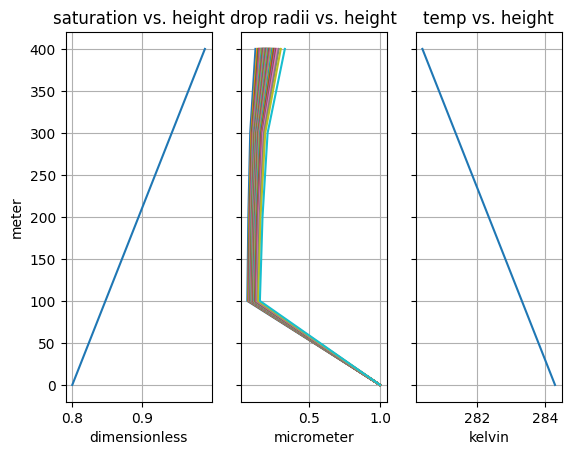

In [21]:
fig, axs = pyplot.subplots(1,3, sharey=True)

axs[0].plot(
   integration_result_with_units[IDX_S],
   integration_result_with_units[IDX_Z],
)
axs[0].set_title("saturation vs. height")

for idx in range(IDX_R0, IDX_RN):
    axs[1].plot(
        integration_result_with_units[idx],
        integration_result_with_units[IDX_Z],
    )
axs[1].set_title("drop radii vs. height")
axs[1].xaxis.set_units(si.um)

axs[2].plot(
    integration_result_with_units[IDX_T],
    integration_result_with_units[IDX_Z],
)
axs[2].set_title("temp vs. height")

for ax in axs:
    ax.grid()